In [48]:
import datetime as dt
import numpy as np
import sqlite3
import pandas as pd
import matplotlib
import seaborn as snb
import matplotlib.pyplot as plt
from sqlalchemy.orm import Session
# Imports the methods needed to abstract classes into tables
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, inspect, func, distinct,desc

In [2]:
engine=create_engine("sqlite:///sql.sqlite")
Base = automap_base()

In [3]:
Base.prepare(engine, reflect=True)

In [4]:
Base.classes.keys()

['Measurements', 'Stations']

In [5]:
Stat=Base.classes.Stations
Meas=Base.classes.Measurements

In [6]:
session = Session(engine)

In [28]:
session.query(Meas.Date).order_by(Meas.Date.desc()).first()

(datetime.date(2017, 8, 23))

In [30]:
last_12=dt.date(2017,8,23)-dt.timedelta(days=365)
print(last_12)

2016-08-23


In [12]:
results=session.query(Meas).filter(Meas.Date>=last_12).all()

In [10]:
df=pd.DataFrame(results,columns=['Date','Prcp'])

In [11]:
df.set_index('Date',inplace=True)

In [12]:
df.head()

,Prcp
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


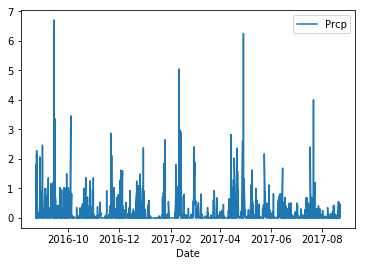

In [13]:
df.plot(kind='line')
plt.show()

In [14]:
df.describe()

,Prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [15]:
## Counting the number of stations:2 ways

session.query(Meas.station).group_by(Meas.station).count()
session.query(func.count(distinct(Meas.station))).all()

[(9)]

In [16]:
## active station:
session.query(Meas.station,func.count(Meas.Prcp)).group_by(Meas.station).order_by(desc(func.count(Meas.Prcp))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

# Most active station is USC00519281

In [17]:
## CREATING THE HISTORGRAM
tobs_results=session.query(Meas.Date,Meas.Tobs).filter(Meas.Date>=last_12).filter(Meas.station=='USC00519281').all()

In [18]:
tobs_df=pd.DataFrame(tobs_results,columns=['Date','Tobs'])
tobs_df.head()

,Date,Tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


[Text(0,0.5,'Frequency')]

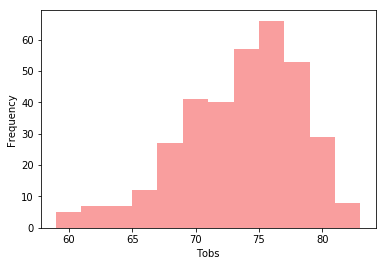

In [19]:
ax= snb.distplot(tobs_df['Tobs'],bins=12,kde=False,label="Tobas", color=snb.desaturate('red',0.9))
ax.set(ylabel='Frequency') 

# Temperature Analysis

In [104]:
def calc_temp(start_Date,end_Date):
    
    st=dt.datetime.strptime(start_Date, "%Y-%m-%d")
    end=dt.datetime.strptime(end_Date, "%Y-%m-%d")
    
    sel= [ 
       func.avg(Meas.Tobs), 
       func.min(Meas.Tobs), 
       func.max(Meas.Tobs)]
    results=session.query(*sel).filter(Meas.Date >= st).filter(Meas.Date<=end).all()
    tmin=[]
    tavg=[]
    tmax=[]
    for ress in results:
        tmin.append(ress[1])
        tmax.append(ress[2]-ress[1])
        tavg.append(ress[0])
    x_axis = 'temp'
    ax=plt.bar(x_axis,tavg,width=0.1,yerr=tmax)
    return results,ax
    

([(72.70862068965518, 56.0, 87.0)], <Container object of 1 artists>)

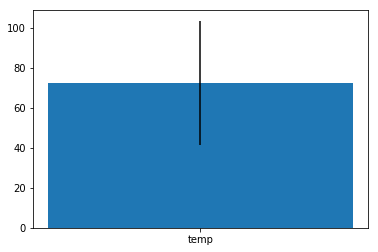

In [105]:
calc_temp("2010-05-20","2011-05-22")